<a href="https://colab.research.google.com/github/VissaMoutafis/Time-Series-Processing-with-Tensorflow/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import argparse
import sys

sys.path.append('..')
import numpy as np
import pandas as pd

from keras import layers, optimizers, losses, metrics
from keras.models import Sequential
from keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model

from sklearn.model_selection import train_test_split

from keras.layers.convolutional import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import MaxPooling1D
from keras.layers import UpSampling2D
from keras import Input
import seaborn as sns
from keras.models import load_model
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt

import tensorflow as tf
	
import webbrowser

import torch

from torchtext.data.utils import get_tokenizer
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

np.random.seed(1)
torch.manual_seed(0)

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

cuda:0


In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
input_dataset_path = 'drive/MyDrive/Project-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Project-Datasets/nasd_query.csv'
DATASET_SIZE = 3
LOOKBACK = 20

In [22]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [23]:
def standardize(X, mean, sigma):
    return (X - mean) / sigma

def reverse_standardize(X, mean, sigma):
    return X * sigma + mean

In [24]:
def create_dataset(_timeseries, time_steps=1, standardized=False, mean = None, sigma = None):
    if not standardized:
      if mean is None:
        mean = _timeseries.mean()
      if sigma is None:
        sigma = _timeseries.std()

      timeseries = standardize(_timeseries, mean, sigma)
    else:
      timeseries = _timeseries
    
    Xs = None
    ys = None
    for i in range(time_steps, len(timeseries)):
        X_i = np.asarray(timeseries[i - time_steps : i]).reshape((1, len(timeseries[i - time_steps : i]), 1))
        Xs = np.concatenate((Xs, X_i)) if Xs is not None else X_i
        y_i = np.asarray(timeseries[i]).reshape((-1, 1))
        ys = np.concatenate((ys, y_i)) if ys is not None else y_i


    return Xs, ys, mean, sigma

In [25]:
class LSTMAutoEncoder_from_paper(nn.Module):
    def __init__(self, input_dim, lstm_units, actv_fn, dropout=None, _optimizer='adam', _loss='mse'):
        super(LSTMAutoEncoder_from_paper, self).__init__()
        self.history = {}
        self.D_train = None
        self.D_test = None
        self.lstm_units = lstm_units
        self.dropout = dropout
        self.optimizer = _optimizer
        self.loss = _loss
        self.input_dim = input_dim
        self.models = {}
        self.input_dim = input_dim      
        self.activation = nn.ReLU()
        self.device = device

        self.model = models.Sequential()
        encoded = layers.LSTM(units=64,input_shape=(input_dim[0],input_dim[-1]))
        self.model.add(encoded)
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.RepeatVector(input_dim[0]))
        self.model.add(layers.LSTM(units=64, return_sequences=True))
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.TimeDistributed(layers.Dense(units=input_dim[-1])))
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def fit(self, X_train, X_test, y_train, y_test, epochs=100, batch_size=4):
      self.D_train = X_train, y_train
      self.D_test = X_test, y_test
      self.history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    
      return self.history
        

In [74]:
from sklearn.preprocessing import StandardScaler

class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, lstm_units, dataset, actv_fn, dropout=None, _optimizer='adam', _loss='mse'):
        super(LSTMAutoEncoder, self).__init__()
        self.D_train = None
        self.D_test = None
        self.lstm_units = lstm_units
        self.dropout = dropout
        self.optimizer = _optimizer
        self.loss = _loss
        self.input_dim = input_dim
        self.models = {}
        self.input_dim = input_dim      
        self.activation = nn.ReLU()
        self.device = device
        self.history = {}
        self.trained = False
        self.eval_data = []
        self.dataset = dataset
        self.mean = []
        self.sigma = []
        self.X_train_all = None
        self.y_train_all = None
        
        self.model = models.Sequential()
        #encoder loop
        _batch_size = 36
        for i, u in enumerate(self.lstm_units):
          self.model.add(BatchNormalization())
          if i == 0: 
            encoded = layers.LSTM(units=u, return_sequences=True, input_shape=self.input_dim, batch_input_shape=(_batch_size, input_dim[0], input_dim[-1]))
            self.model.add(encoded)

          elif i == len(self.lstm_units) - 1:
            encoded = layers.LSTM(units=u,batch_input_shape=(_batch_size, input_dim[0], input_dim[-1]))
            self.model.add(encoded)
            self.decoded = layers.RepeatVector(input_dim[0])

          else: 
            self.model.add(layers.LSTM(units=u, return_sequences=True,batch_input_shape=(_batch_size, input_dim[0], input_dim[-1])))
          if self.dropout is not None:
            self.model.add(layers.Dropout(self.dropout))

        self.model.add(self.decoded)

        #decoder loop 
        for i, u in enumerate(self.lstm_units[::-1]):
          self.model.add(BatchNormalization())
          if i == len(self.lstm_units) - 1:
            encoded = layers.LSTM(units=u,return_sequences=True,batch_input_shape=(_batch_size, input_dim[0], input_dim[-1]))
            self.model.add(encoded)
          else: 
            self.model.add(layers.LSTM(units=u, return_sequences=True,batch_input_shape=(_batch_size, input_dim[0], input_dim[-1])))
          if self.dropout is not None:
            self.model.add(layers.Dropout(self.dropout))

        # final output layer
        self.model.add(layers.TimeDistributed(layers.Dense(units=input_dim[-1], activation="tanh")))
        
        self.model.compile(optimizer='adam', loss=self.loss)

    def fit(self, X, y, epochs=50, batch_size=36):
      _history = {}
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
      _history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    
      return _history
    
    def solve(self, lookback=LOOKBACK, epochs=50, batch_size=36):
      self.trained = True

      for timeseries in self.dataset:
        # preprocess timeseries
        X_normalized, y_normalized, _mean, _sigma = create_dataset(timeseries,LOOKBACK)
        self.mean.append(_mean)
        self.sigma.append(_sigma)

        # train the model
        train_lim = 5*len(X_normalized)//6
        X_train, X_test, y_train, y_test = X_normalized[:train_lim], X_normalized[train_lim:], y_normalized[:train_lim], y_normalized[train_lim:]
          
        #X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.33, shuffle=True)
        self.X_train_all = (
          X_train
          if self.X_train_all is None
          else np.concatenate((self.X_train_all,X_train))
        )
        self.y_train_all = (
          y_train
          if self.y_train_all is None
          else np.concatenate((self.y_train_all, y_train))
        )

        # add the eval data in the respective array
        self.eval_data.append((X_test,y_test))

      self.history = self.fit(self.X_train_all, self.y_train_all, epochs = epochs, batch_size = batch_size)

In [75]:
model1 = LSTMAutoEncoder((LOOKBACK, 1),[64, 64,100],timeseries_df.to_numpy(),nn.ReLU,dropout=0.3)

In [76]:
model1.solve(lookback=LOOKBACK, epochs=50, batch_size = 36)

Epoch 1/50
33/33 [==============================] - 22s 226ms/step - loss: 0.3226 - val_loss: 0.6935
Epoch 2/50
33/33 [==============================] - 4s 125ms/step - loss: 0.2416 - val_loss: 0.5828
Epoch 3/50
33/33 [==============================] - 4s 125ms/step - loss: 0.2137 - val_loss: 0.5882
Epoch 4/50
33/33 [==============================] - 4s 129ms/step - loss: 0.2084 - val_loss: 0.5234
Epoch 5/50
33/33 [==============================] - 4s 127ms/step - loss: 0.1900 - val_loss: 0.6210
Epoch 6/50
33/33 [==============================] - 4s 127ms/step - loss: 0.1957 - val_loss: 0.4486
Epoch 7/50
33/33 [==============================] - 4s 125ms/step - loss: 0.1945 - val_loss: 0.4433
Epoch 8/50
33/33 [==============================] - 4s 128ms/step - loss: 0.1895 - val_loss: 0.3967
Epoch 9/50
33/33 [==============================] - 4s 125ms/step - loss: 0.1886 - val_loss: 0.3796
Epoch 10/50
33/33 [==============================] - 4s 123ms/step - loss: 0.1831 - val_loss: 0.299

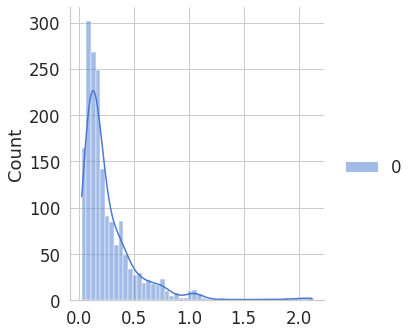

In [77]:
import seaborn as sns
X_train_pred = model1.model.predict(model1.X_train_all)

train_mae_loss = np.mean(np.abs(X_train_pred - model1.X_train_all), axis=1)
sns.displot(train_mae_loss, bins=50, kde=True);

In [79]:
def plot_graphs(model, timeseries_idx=None):
        if not model.trained:
            raise Exception("Problem not solved")

        figure(figsize=(20, 10))
        lgnd = []
        for i in timeseries_idx:
            print(f'Ploting pred for {self.labels[i]}')
            lgnd += [f"{self.labels[i]}-True", f"{self.labels[i]}-Pred"]
            X, y = self.eval_data[i]
            plt.plot(
                range(len(y.reshape(-1))),
                reverse_normalize(y, self.max[i], self.min[i]).reshape(-1),
                "o-",
            )
            y_pred = self.model.predict(X)
            plt.plot(
                range(len(y_pred.reshape(-1))),
                reverse_normalize(y_pred, self.max[i], self.min[i]).reshape(-1),
                "o-",
            )

        plt.legend(lgnd)
        plt.show()

In [80]:
def plot_anomalies(model):
  fig,axes = plt.subplots(1,len(TIME_SERIES_ID),figsize = (30,10))
  timeseries_idx = range(len(TIME_SERIES_ID))
  for i in timeseries_idx:
    X_test, y_test = model.eval_data[i]
    X_test_pred = model.model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    # in the last commit for threshold 3 we had double the anomalies. We used to have threshold 5. Now for 5 we only have 1 anomaly
    THRESHOLD = 0.5
    test_score_df = pd.DataFrame()
    test_score_df['loss'] = test_mae_loss.flatten()
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > THRESHOLD
    test_score_df['close'] = X_test[:,1]
    #check if we are tresholding right
    #plt.plot(test_score_df.index, test_score_df.loss, label='loss')
    #plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
    #plt.xticks(rotation=25)
    #plt.legend();

    anomalies = test_score_df[test_score_df.anomaly == True]
    anomaly =  np.array(anomalies.close)

    test_score_df_close_new =  np.array(test_score_df.close)
    #test_score_df_close_new = test_score_df_close_new.reshape(test_score_df_close_new.shape[0],1)#scaler.transform(test_score_df_close_new.reshape(test_score_df_close_new.shape[0],1))
    plt.rcParams['figure.figsize'] = [30, 10]
    axes[i].plot(
      test_score_df.index, 
      reverse_standardize(test_score_df_close_new,model.mean[i], model.sigma[i]).flatten(),
      label='stock real price'
    );
    axes[i].scatter(anomalies.index,
                    reverse_standardize(anomaly,model.mean[i], model.sigma[i]).flatten(),
                    color=sns.color_palette()[3],
                    s=52,
                    label='anomaly')
    axes[i].title.set_text('Stock Price vs Anomalies for timeseries:')
  plt.xticks(rotation=25)
  plt.legend();

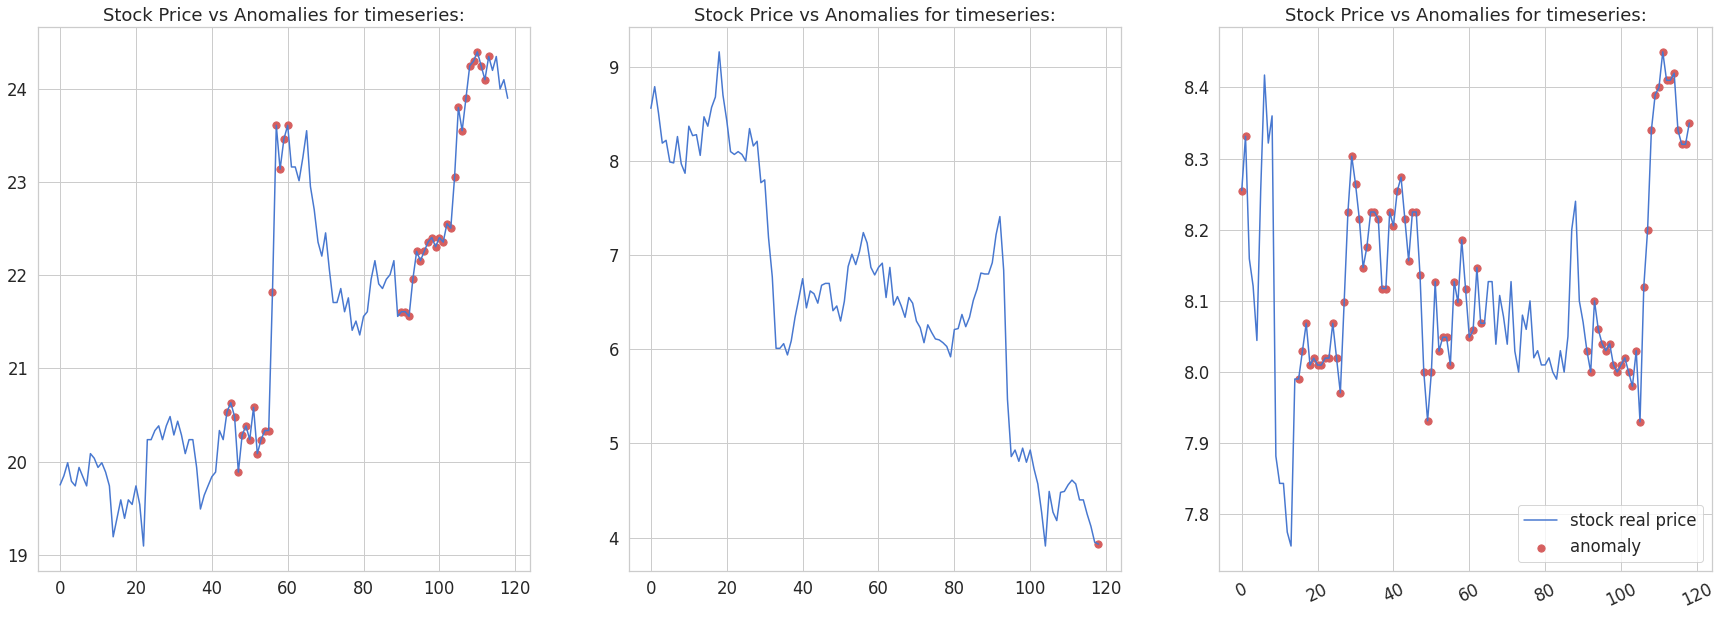

In [81]:
plot_anomalies(model1)

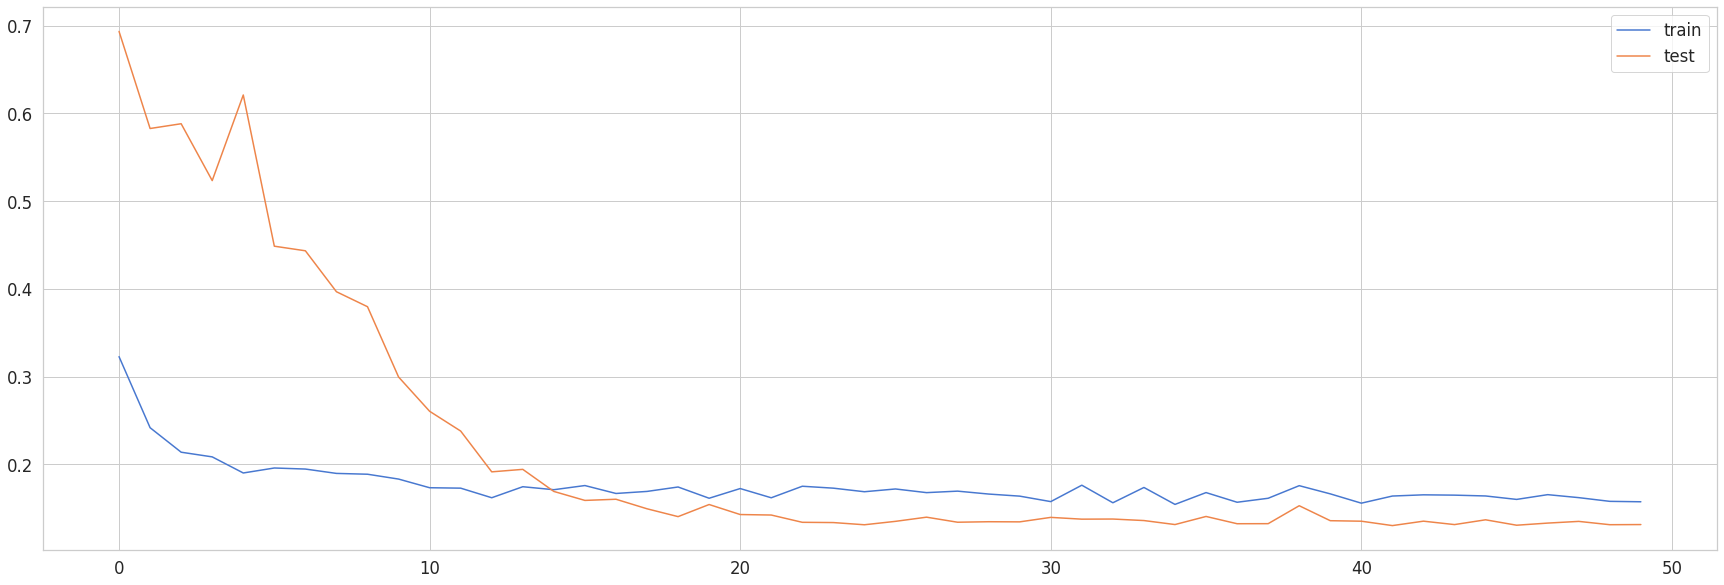

In [83]:
plt.plot(model1.history.history['loss'], label='train')
plt.plot(model1.history.history['val_loss'], label='test')
plt.legend()